In [1]:
from matplotlib import pyplot as plt
%matplotlib inline
import tensorflow as tf

In [2]:
import glob
import numpy as np
from PIL import Image
import re
images = glob.glob('training/images/*')
gt_images = glob.glob('training/groundtruth/*')
test_images = glob.glob('test_set_images/*')
def sorted_alph(data):
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alph = lambda key: [convert(c) for c in re.split('([0-9]+)', key)]
    return sorted(data, key=alph)
test_images = sorted_alph(test_images)

In [3]:
print(len(images))
print(len(gt_images))
print(len(test_images))

100
100
50


In [4]:
def to_numpy(images, width, height):
    arr = []
    for i in images:
        whole_img = np.asarray(Image.open(i))
        for w in range(0, whole_img.shape[1], width):
            for h in range(0, whole_img.shape[0], height):
                if whole_img.ndim == 3:
                    arr.append(whole_img[w:w+width,h:h+height,:])
                else:
                    arr.append(whole_img[w:w+width,h:h+height])
    return np.array(arr)

In [5]:
np_imgs = to_numpy(images, 400, 400)
np_imgs.shape

(100, 400, 400, 3)

In [6]:
np_gt_imgs = to_numpy(gt_images, 400, 400)
np_gt_imgs = np.reshape(np_gt_imgs, (len(np_gt_imgs), 400, 400, 1))
np_gt_imgs.shape

(100, 400, 400, 1)

In [7]:
np_test_imgs = to_numpy(test_images, 304, 304)
np_test_imgs.shape

(200, 304, 304, 3)

In [8]:
def crop(np_img, crop_width, crop_height):
    start_w = np_img.shape[1] - crop_width
    start_h = np_img.shape[0] - crop_height
    return np_img[start_w:start_w+crop_width, start_h:start_h+crop_height, :]

In [9]:
def get_random_train(imgs, gt, crop_width, crop_height):
    x = []
    y = []
    width = imgs[0].shape[1]
    height = imgs[0].shape[0]
    range_w = width - crop_width
    range_h = height - crop_height
    for i in range(len(imgs)):
        start_w = np.random.randint(0, range_w + 1)
        start_h = np.random.randint(0, range_h + 1)
        x.append(imgs[i][start_w:start_w+crop_width, start_h:start_h+crop_height, :])
        y.append(gt[i][start_w:start_w+crop_width, start_h:start_h+crop_height, :])
    return np.asarray(x), np.asarray(y)

In [10]:
crop_np_imgs, crop_np_gt_imgs = get_random_train(np_imgs, np_gt_imgs, 304, 304)

In [11]:
crop_np_imgs.shape

(100, 304, 304, 3)

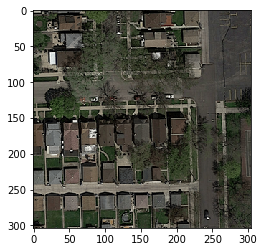

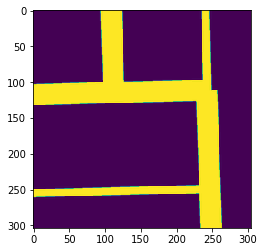

In [12]:
plt.imshow(crop_np_imgs[4], interpolation='nearest')
plt.show()
plt.imshow(crop_np_gt_imgs[4], interpolation='nearest')
plt.show()

In [13]:
def split_data(x, y, ratio, seed=1):
    np.random.seed(seed)
    num_row = len(y)
    indices = np.random.permutation(num_row)
    index_split = int(np.floor(ratio * num_row))
    index_tr = indices[: index_split]
    index_te = indices[index_split:]
    x_tr = x[index_tr]
    x_te = x[index_te]
    y_tr = y[index_tr]
    y_te = y[index_te]
    return x_tr, x_te, y_tr, y_te

In [14]:
split = 0.8

X_train, X_test, y_train, y_test = split_data(crop_np_imgs, crop_np_gt_imgs, split)

In [15]:
X_train, X_test, y_train, y_test = X_train/255, X_test/255, y_train/255, y_test/255

In [16]:
input_shape = (len(X_train), 304, 304, 3)
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Conv2D(32, 3, activation='relu', padding="same", input_shape=input_shape[1:]))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2),strides=(2, 2), padding='valid'))
model.add(tf.keras.layers.Conv2D(32, 3, activation='relu', padding="same"))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2),strides=(2, 2), padding='valid'))
model.add(tf.keras.layers.Conv2D(32, 3, activation='relu', padding="same"))
model.add(tf.keras.layers.UpSampling2D(size=(2, 2)))
model.add(tf.keras.layers.Conv2D(32, 3, activation='relu', padding="same"))
model.add(tf.keras.layers.UpSampling2D(size=(2, 2)))
model.add(tf.keras.layers.Conv2D(1, 3, activation='relu', padding="same"))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 304, 304, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 152, 152, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 152, 152, 32)      9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 76, 76, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 76, 76, 32)        9248      
                                                                 
 up_sampling2d (UpSampling2D  (None, 152, 152, 32)     0

In [17]:
import tensorflow.keras.backend as kb
def dice_coef(y_true, y_pred, smooth=1):
    intersection = kb.sum(kb.abs(y_true * y_pred), axis=-1)
    return (2. * intersection + smooth) / (kb.sum(kb.square(y_true),-1) + kb.sum(kb.square(y_pred),-1) + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

In [18]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss=dice_coef_loss,#tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy(),
                       tf.keras.metrics.FalseNegatives()])

model.fit(X_train, y_train, epochs=5)
model.evaluate(X_test, y_test)

Epoch 1/5
3/3 [==============================] - 10s 3s/step - loss: 0.0888 - binary_accuracy: 0.7668 - false_negatives: 1723745.0000
Epoch 2/5
3/3 [==============================] - 10s 3s/step - loss: 0.0855 - binary_accuracy: 0.7668 - false_negatives: 1723745.0000
Epoch 3/5
3/3 [==============================] - 9s 3s/step - loss: 0.0848 - binary_accuracy: 0.7668 - false_negatives: 1723745.0000
Epoch 4/5
3/3 [==============================] - 9s 3s/step - loss: 0.0838 - binary_accuracy: 0.7668 - false_negatives: 1723745.0000
Epoch 5/5
1/1 [==============================] - 0s 417ms/step - loss: 0.0741 - binary_accuracy: 0.7913 - false_negatives: 385757.0000


[0.074057437479496, 0.791293203830719, 385757.0]

In [19]:
test = model.predict(X_test)

In [20]:
tr = model.predict(X_train)

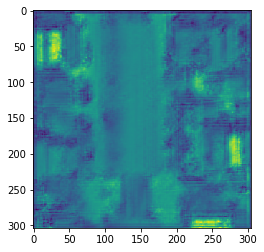

In [21]:
plt.imshow(tr[3], interpolation='nearest')
plt.show()

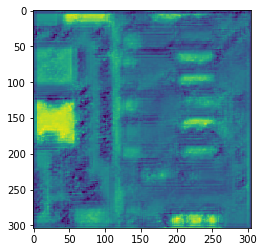

In [22]:
plt.imshow(test[3], interpolation='nearest')
plt.show()

In [23]:
pr = model.predict(np_test_imgs)

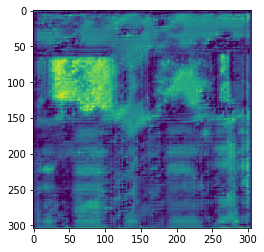

In [24]:
plt.imshow(pr[0], interpolation='nearest')
plt.show()

In [25]:
pr[0][0:0+16,0:0+16,:].sum()/65280 #/65280

0.03755441179462508

In [37]:
sized_pr = []
for i in range(0,len(pr),4):
    a = np.concatenate((pr[i],pr[i+1]),axis=1)
    b = np.concatenate((pr[i+2],pr[i+3]),axis=1)
    sized_pr.append(np.concatenate((a,b),axis=0))
sized_pr = np.asarray(sized_pr)
sized_pr.shape

(50, 608, 608, 1)

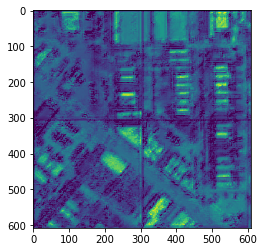

In [42]:
plt.imshow(sized_pr[4], interpolation='nearest')
plt.show()

In [43]:
sized_pr[0].sum() 

5121017.0

In [44]:
#avg, we could do double threshhold
def outputx16(nump, treshhold):
    pred = []
    for w in range(0,nump.shape[1],16):
        for h in range(0,nump.shape[0],16):
            if nump[w:w+16,h:h+16,:].sum()/65280 > treshhold:
                pred.append(1)
            else:
                pred.append(0)
    return np.asarray(pred)

In [51]:
pred_first = outputx16(sized_pr[0],0.067)
print(pred_first.shape)
pred_first = np.reshape(pred_first, (38, 38))
print(pred_first.shape)

(1444,)
(38, 38)


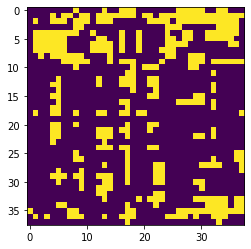

In [52]:
plt.imshow(pred_first, interpolation='nearest')
plt.show()

In [32]:
model.add(tf.keras.layers.Conv2D(32,3,activation='relu',padding='same',kernel_initializer='HeNormal',input_shape=input_shape[1:]))
model.add(tf.keras.layers.Conv2D(32,3,activation='relu',padding='same',kernel_initializer='HeNormal'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.MaxPooling2D(pool_size = (2,2)))

model.add(tf.keras.layers.Conv2DTranspose(32,(3,3),strides=(2,2),padding='same'))
#merge = concatenate([up, skip_layer_input], axis=3)
model.add(tf.keras.layers.Conv2D(32, 3,  activation='relu',padding='same',kernel_initializer='HeNormal'))
model.add(tf.keras.layers.Conv2D(32,3, activation='relu',padding='same',kernel_initializer='HeNormal'))
model.add(tf.keras.layers.Conv2D(1,3, activation='relu',padding='same',kernel_initializer='HeNormal'))

In [33]:
model.add(tf.keras.layers.Conv2D(25, 3, activation='relu', padding="same", input_shape=input_shape[1:]))
model.add(tf.keras.layers.Conv2D(25, 3, activation='relu', padding="same", input_shape=input_shape[1:]))
#y = tf.keras.layers.Cropping2D(cropping=((2, 2), (4, 4)))(y)
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2),strides=(2, 2), padding='valid'))
model.add(tf.keras.layers.Conv2D(50, 3, activation='relu', padding="same", input_shape=input_shape[1:]))
model.add(tf.keras.layers.Conv2D(50, 3, activation='relu', padding="same", input_shape=input_shape[1:]))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2),strides=(2, 2), padding='valid'))
model.add(tf.keras.layers.Conv2D(100, 3, activation='relu', padding="same", input_shape=input_shape[1:]))
model.add(tf.keras.layers.Conv2D(100, 3, activation='relu', padding="same", input_shape=input_shape[1:]))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2),strides=(2, 2), padding='valid'))
model.add(tf.keras.layers.Conv2D(200, 3, activation='relu', padding="same", input_shape=input_shape[1:]))
model.add(tf.keras.layers.Conv2D(200, 3, activation='relu', padding="same", input_shape=input_shape[1:]))
model.add(tf.keras.layers.UpSampling2D(size=(2, 2)))
model.add(tf.keras.layers.Conv2D(100, 3, activation='relu', padding="same", input_shape=input_shape[1:]))
model.add(tf.keras.layers.Conv2D(100, 3, activation='relu', padding="same", input_shape=input_shape[1:]))
model.add(tf.keras.layers.UpSampling2D(size=(2, 2)))
model.add(tf.keras.layers.Conv2D(50, 3, activation='relu', padding="same", input_shape=input_shape[1:]))
model.add(tf.keras.layers.Conv2D(50, 3, activation='relu', padding="same", input_shape=input_shape[1:]))
model.add(tf.keras.layers.UpSampling2D(size=(2, 2)))
model.add(tf.keras.layers.Conv2D(25, 3, activation='relu', padding="same", input_shape=input_shape[1:]))
model.add(tf.keras.layers.Conv2D(25, 3, activation='relu', padding="same", input_shape=input_shape[1:]))
model.add(tf.keras.layers.Conv2D(1, 1, activation='relu', padding="same", input_shape=input_shape[1:]))

In [34]:
input_shape = (len(X_train), 400, 400, 3)
model = tf.keras.models.Sequential()
x = tf.random.normal(input_shape)
y = tf.keras.layers.Conv2D(25, 3, activation='relu', padding="same", input_shape=input_shape[1:])(x)
y = tf.keras.layers.Conv2D(25, 3, activation='relu', padding="same", input_shape=input_shape[1:])(y)
#y = tf.keras.layers.Cropping2D(cropping=((2, 2), (4, 4)))(y)
y = tf.keras.layers.MaxPooling2D(pool_size=(2, 2),strides=(2, 2), padding='valid')(y)
y = tf.keras.layers.Conv2D(50, 3, activation='relu', padding="same", input_shape=input_shape[1:])(y)
y = tf.keras.layers.Conv2D(50, 3, activation='relu', padding="same", input_shape=input_shape[1:])(y)
y = tf.keras.layers.MaxPooling2D(pool_size=(2, 2),strides=(2, 2), padding='valid')(y)
y = tf.keras.layers.Conv2D(100, 3, activation='relu', padding="same", input_shape=input_shape[1:])(y)
y = tf.keras.layers.Conv2D(100, 3, activation='relu', padding="same", input_shape=input_shape[1:])(y)
y = tf.keras.layers.MaxPooling2D(pool_size=(2, 2),strides=(2, 2), padding='valid')(y)
y = tf.keras.layers.Conv2D(200, 3, activation='relu', padding="same", input_shape=input_shape[1:])(y)
y = tf.keras.layers.Conv2D(200, 3, activation='relu', padding="same", input_shape=input_shape[1:])(y)
y = tf.keras.layers.UpSampling2D(size=(2, 2))(y)
y = tf.keras.layers.Conv2D(100, 3, activation='relu', padding="same", input_shape=input_shape[1:])(y)
y = tf.keras.layers.Conv2D(100, 3, activation='relu', padding="same", input_shape=input_shape[1:])(y)
y = tf.keras.layers.UpSampling2D(size=(2, 2))(y)
y = tf.keras.layers.Conv2D(50, 3, activation='relu', padding="same", input_shape=input_shape[1:])(y)
y = tf.keras.layers.Conv2D(50, 3, activation='relu', padding="same", input_shape=input_shape[1:])(y)
y = tf.keras.layers.UpSampling2D(size=(2, 2))(y)
y = tf.keras.layers.Conv2D(25, 3, activation='relu', padding="same", input_shape=input_shape[1:])(y)
y = tf.keras.layers.Conv2D(25, 3, activation='relu', padding="same", input_shape=input_shape[1:])(y)
y = tf.keras.layers.Conv2D(1, 1, activation='relu', padding="same", input_shape=input_shape[1:])(y)
model.add(y)
model.summary()

TypeError: The added layer must be an instance of class Layer. Received: layer=[[[[1.1065285e-04]
   [0.0000000e+00]
   [3.0783500e-05]
   ...
   [0.0000000e+00]
   [0.0000000e+00]
   [0.0000000e+00]]

  [[1.8625335e-03]
   [2.1481395e-03]
   [2.8068367e-03]
   ...
   [0.0000000e+00]
   [0.0000000e+00]
   [0.0000000e+00]]

  [[7.3352997e-04]
   [1.5848759e-04]
   [2.3281462e-03]
   ...
   [0.0000000e+00]
   [0.0000000e+00]
   [0.0000000e+00]]

  ...

  [[0.0000000e+00]
   [0.0000000e+00]
   [0.0000000e+00]
   ...
   [0.0000000e+00]
   [0.0000000e+00]
   [7.0577388e-04]]

  [[0.0000000e+00]
   [0.0000000e+00]
   [0.0000000e+00]
   ...
   [0.0000000e+00]
   [0.0000000e+00]
   [2.6980171e-04]]

  [[0.0000000e+00]
   [0.0000000e+00]
   [0.0000000e+00]
   ...
   [0.0000000e+00]
   [0.0000000e+00]
   [3.1921751e-05]]]


 [[[3.1591422e-04]
   [4.2720488e-04]
   [3.0694052e-04]
   ...
   [0.0000000e+00]
   [0.0000000e+00]
   [0.0000000e+00]]

  [[2.5347329e-03]
   [2.8611517e-03]
   [2.8941690e-03]
   ...
   [0.0000000e+00]
   [0.0000000e+00]
   [0.0000000e+00]]

  [[8.6181983e-04]
   [0.0000000e+00]
   [2.5325401e-03]
   ...
   [0.0000000e+00]
   [0.0000000e+00]
   [0.0000000e+00]]

  ...

  [[0.0000000e+00]
   [0.0000000e+00]
   [0.0000000e+00]
   ...
   [0.0000000e+00]
   [0.0000000e+00]
   [8.4560661e-04]]

  [[0.0000000e+00]
   [0.0000000e+00]
   [0.0000000e+00]
   ...
   [0.0000000e+00]
   [0.0000000e+00]
   [1.0903225e-03]]

  [[0.0000000e+00]
   [0.0000000e+00]
   [0.0000000e+00]
   ...
   [0.0000000e+00]
   [0.0000000e+00]
   [2.5252748e-04]]]


 [[[4.4387244e-04]
   [5.4311304e-04]
   [3.7780283e-06]
   ...
   [0.0000000e+00]
   [0.0000000e+00]
   [0.0000000e+00]]

  [[2.5278239e-03]
   [2.9630028e-03]
   [2.7315631e-03]
   ...
   [0.0000000e+00]
   [0.0000000e+00]
   [0.0000000e+00]]

  [[9.7570947e-04]
   [0.0000000e+00]
   [8.4519084e-04]
   ...
   [0.0000000e+00]
   [0.0000000e+00]
   [0.0000000e+00]]

  ...

  [[0.0000000e+00]
   [0.0000000e+00]
   [0.0000000e+00]
   ...
   [0.0000000e+00]
   [0.0000000e+00]
   [1.1117691e-03]]

  [[0.0000000e+00]
   [0.0000000e+00]
   [0.0000000e+00]
   ...
   [0.0000000e+00]
   [0.0000000e+00]
   [9.9703670e-04]]

  [[0.0000000e+00]
   [0.0000000e+00]
   [0.0000000e+00]
   ...
   [0.0000000e+00]
   [0.0000000e+00]
   [1.8489000e-04]]]


 ...


 [[[4.0993898e-04]
   [3.4079357e-04]
   [5.0024939e-04]
   ...
   [0.0000000e+00]
   [0.0000000e+00]
   [0.0000000e+00]]

  [[2.9945078e-03]
   [2.9092184e-03]
   [3.2461127e-03]
   ...
   [0.0000000e+00]
   [0.0000000e+00]
   [0.0000000e+00]]

  [[6.5075961e-04]
   [3.8400193e-04]
   [2.8552716e-03]
   ...
   [0.0000000e+00]
   [0.0000000e+00]
   [0.0000000e+00]]

  ...

  [[0.0000000e+00]
   [0.0000000e+00]
   [0.0000000e+00]
   ...
   [0.0000000e+00]
   [0.0000000e+00]
   [9.0524741e-04]]

  [[1.2318564e-04]
   [0.0000000e+00]
   [0.0000000e+00]
   ...
   [0.0000000e+00]
   [0.0000000e+00]
   [9.5534243e-04]]

  [[0.0000000e+00]
   [0.0000000e+00]
   [0.0000000e+00]
   ...
   [0.0000000e+00]
   [0.0000000e+00]
   [1.3176381e-04]]]


 [[[7.9695531e-04]
   [5.5064732e-04]
   [8.8819640e-04]
   ...
   [0.0000000e+00]
   [0.0000000e+00]
   [0.0000000e+00]]

  [[2.5890956e-03]
   [2.1563021e-03]
   [2.6758611e-03]
   ...
   [0.0000000e+00]
   [0.0000000e+00]
   [0.0000000e+00]]

  [[4.7477323e-04]
   [0.0000000e+00]
   [2.0334162e-03]
   ...
   [0.0000000e+00]
   [0.0000000e+00]
   [0.0000000e+00]]

  ...

  [[0.0000000e+00]
   [0.0000000e+00]
   [0.0000000e+00]
   ...
   [0.0000000e+00]
   [0.0000000e+00]
   [1.3456137e-03]]

  [[0.0000000e+00]
   [0.0000000e+00]
   [0.0000000e+00]
   ...
   [0.0000000e+00]
   [0.0000000e+00]
   [1.0726784e-03]]

  [[0.0000000e+00]
   [0.0000000e+00]
   [0.0000000e+00]
   ...
   [0.0000000e+00]
   [0.0000000e+00]
   [0.0000000e+00]]]


 [[[9.0116676e-04]
   [3.9187001e-04]
   [8.0872857e-04]
   ...
   [0.0000000e+00]
   [0.0000000e+00]
   [0.0000000e+00]]

  [[2.8323729e-03]
   [2.6702941e-03]
   [2.8909859e-03]
   ...
   [0.0000000e+00]
   [0.0000000e+00]
   [0.0000000e+00]]

  [[8.8944274e-04]
   [1.8137333e-05]
   [2.5576898e-03]
   ...
   [0.0000000e+00]
   [0.0000000e+00]
   [0.0000000e+00]]

  ...

  [[0.0000000e+00]
   [0.0000000e+00]
   [0.0000000e+00]
   ...
   [0.0000000e+00]
   [0.0000000e+00]
   [8.8025478e-04]]

  [[0.0000000e+00]
   [0.0000000e+00]
   [0.0000000e+00]
   ...
   [0.0000000e+00]
   [0.0000000e+00]
   [9.2960382e-04]]

  [[0.0000000e+00]
   [0.0000000e+00]
   [0.0000000e+00]
   ...
   [0.0000000e+00]
   [0.0000000e+00]
   [7.5365067e-05]]]] of type <class 'tensorflow.python.framework.ops.EagerTensor'>.

In [ ]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Conv2D(32, 3, activation='relu', padding="same", input_shape=input_shape[1:]))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2),strides=(2, 2), padding='valid'))
model.add(tf.keras.layers.Conv2D(32, 3, activation='relu', padding="same", input_shape=input_shape[1:]))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2),strides=(2, 2), padding='valid'))
model.add(tf.keras.layers.Conv2D(32, 3, activation='relu', padding="same", input_shape=input_shape[1:]))
model.add(tf.keras.layers.UpSampling2D(size=(2, 2)))
model.add(tf.keras.layers.Conv2D(32, 3, activation='relu', padding="same", input_shape=input_shape[1:]))
model.add(tf.keras.layers.UpSampling2D(size=(2, 2)))
model.add(tf.keras.layers.Conv2D(1, 3, activation='relu', padding="same", input_shape=input_shape[1:]))

In [ ]:
x = tf.random.normal(input_shape)
y = tf.keras.layers.Conv2D(3, 3, activation='relu', padding="same", input_shape=input_shape[1:])(x)
y = tf.keras.layers.Conv2D(3, 3, activation='relu', padding="same", input_shape=input_shape[1:])(y)
y = tf.keras.layers.MaxPooling2D(pool_size=(2, 2),strides=(1, 1), padding='valid')(y)
y = tf.keras.layers.Conv2D(3, 3, activation='relu', padding="same", input_shape=input_shape[1:])(y)
y = tf.keras.layers.Conv2D(3, 3, activation='relu', padding="same", input_shape=input_shape[1:])(y)
y = tf.keras.layers.MaxPooling2D(pool_size=(2, 2),strides=(1, 1), padding='valid')(y)
y = tf.keras.layers.Conv2D(3, 3, activation='relu', padding="same", input_shape=input_shape[1:])(y)
y = tf.keras.layers.Conv2D(3, 3, activation='relu', padding="same", input_shape=input_shape[1:])(y)
y = tf.keras.layers.MaxPooling2D(pool_size=(2, 2),strides=(1, 1), padding='valid')(y)
y = tf.keras.layers.Conv2D(3, 3, activation='relu', padding="same", input_shape=input_shape[1:])(y)
y = tf.keras.layers.Conv2D(3, 3, activation='relu', padding="same", input_shape=input_shape[1:])(y)
y = tf.keras.layers.MaxPooling2D(pool_size=(2, 2),strides=(1, 1), padding='valid')(y)
y = tf.keras.layers.Conv2D(3, 3, activation='relu', padding="same", input_shape=input_shape[1:])(y)
y = tf.keras.layers.Conv2D(3, 3, activation='relu', padding="same", input_shape=input_shape[1:])(y)
y = tf.keras.layers.UpSampling2D(size=(1, 2))(y)
y = tf.keras.layers.Conv2D(3, 3, activation='relu', padding="same", input_shape=input_shape[1:])(y)
y = tf.keras.layers.Conv2D(3, 3, activation='relu', padding="same", input_shape=input_shape[1:])(y)
y = tf.keras.layers.UpSampling2D(size=(1, 2))(y)
y = tf.keras.layers.Conv2D(3, 3, activation='relu', padding="same", input_shape=input_shape[1:])(y)
y = tf.keras.layers.Conv2D(3, 3, activation='relu', padding="same", input_shape=input_shape[1:])(y)
y = tf.keras.layers.UpSampling2D(size=(1, 2))(y)
y = tf.keras.layers.Conv2D(3, 3, activation='relu', padding="same", input_shape=input_shape[1:])(y)
y = tf.keras.layers.Conv2D(3, 3, activation='relu', padding="same", input_shape=input_shape[1:])(y)
y = tf.keras.layers.UpSampling2D(size=(1, 2))(y)
y = tf.keras.layers.Conv2D(3, 3, activation='relu', padding="same", input_shape=input_shape[1:])(y)
y = tf.keras.layers.Conv2D(3, 3, activation='relu', padding="same", input_shape=input_shape[1:])(y)
y = tf.keras.layers.Conv2D(1, 1, activation='relu', padding="same", input_shape=input_shape[1:])(y)
print(y.shape)

In [ ]:
import tensorflow as tf
mnist = tf.keras.datasets.mnist

(x_train, y_train),(x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(10, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit(x_train, y_train, epochs=1)
model.evaluate(x_test, y_test)

In [ ]:
model.add(tf.keras.layers.Conv2D(3, 3, activation='relu', padding="same", input_shape=input_shape[1:]))
model.add(tf.keras.layers.Conv2D(3, 3, activation='relu', padding="same", input_shape=input_shape[1:]))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2),strides=(1, 1), padding='valid'))
model.add(tf.keras.layers.Conv2D(3, 3, activation='relu', padding="same", input_shape=input_shape[1:]))
model.add(tf.keras.layers.Conv2D(3, 3, activation='relu', padding="same", input_shape=input_shape[1:]))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2),strides=(1, 1), padding='valid'))
model.add(tf.keras.layers.Conv2D(3, 3, activation='relu', padding="same", input_shape=input_shape[1:]))
model.add(tf.keras.layers.Conv2D(3, 3, activation='relu', padding="same", input_shape=input_shape[1:]))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2),strides=(1, 1), padding='valid'))
model.add(tf.keras.layers.Conv2D(3, 3, activation='relu', padding="same", input_shape=input_shape[1:]))
model.add(tf.keras.layers.Conv2D(3, 3, activation='relu', padding="same", input_shape=input_shape[1:]))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2),strides=(1, 1), padding='valid'))
model.add(tf.keras.layers.Conv2D(3, 3, activation='relu', padding="same", input_shape=input_shape[1:]))
model.add(tf.keras.layers.Conv2D(3, 3, activation='relu', padding="same", input_shape=input_shape[1:]))
model.add(tf.keras.layers.UpSampling2D(size=(1, 2)))
model.add(tf.keras.layers.Conv2D(3, 3, activation='relu', padding="same", input_shape=input_shape[1:]))
model.add(tf.keras.layers.Conv2D(3, 3, activation='relu', padding="same", input_shape=input_shape[1:]))
model.add(tf.keras.layers.UpSampling2D(size=(1, 2)))
model.add(tf.keras.layers.Conv2D(3, 3, activation='relu', padding="same", input_shape=input_shape[1:]))
model.add(tf.keras.layers.Conv2D(3, 3, activation='relu', padding="same", input_shape=input_shape[1:]))
model.add(tf.keras.layers.UpSampling2D(size=(1, 2)))
model.add(tf.keras.layers.Conv2D(3, 3, activation='relu', padding="same", input_shape=input_shape[1:]))
model.add(tf.keras.layers.Conv2D(3, 3, activation='relu', padding="same", input_shape=input_shape[1:]))
model.add(tf.keras.layers.UpSampling2D(size=(1, 2)))
model.add(tf.keras.layers.Conv2D(3, 3, activation='relu', padding="same", input_shape=input_shape[1:]))
model.add(tf.keras.layers.Conv2D(3, 3, activation='relu', padding="same", input_shape=input_shape[1:]))
model.add(tf.keras.layers.Conv2D(1, 1, activation='relu', padding="same", input_shape=input_shape[1:]))

In [ ]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import tensorflow as tf
from tensorflow import keras
#from tensorflow import layers
from tensorflow.keras import layers

import matplotlib.pyplot as plt

#train_images =
#train_labels =
#test_images =
"""
X_train = X
y_train = Y
X_test = X_test
"""

cifar10 = keras.datasets.cifar10
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()
print(train_images.shape)


class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
#class_names = ['road', 'not_road']

#import sys; sys.exit()

shapeForInput = int(400/16)

#model
model = keras.Sequential()
model.add(layers.Conv2D(32, (3,3), strides=(1,1), padding='valid', activation='relu', input_shape=(32, 32, 3))) # 32x32 RGB images
#model.add(layers.Conv2D(32, (3,3), strides=(1,1), padding='valid', activation='relu', input_shape=(shapeForInput, shapeForInput, 3)))
#padding = "same"
model.add(layers.MaxPool2D((2,2)))
model.add(layers.Conv2D(32, 3, activation='relu'))
model.add(layers.MaxPool2D((2,2)))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10))
print(model.summary())

#import sys; sys.exit()


loss = keras.losses.SparseCategoricalCrossentropy(from_logits = True)
optim = keras.optimizers.Adam(lr=0.001)
metrics = ['accuracy']

model.compile(optimizer=optim, loss=loss) #, metrics=metrics)

#training
batch_size = 64
epochs = 5 #affect training

model.fit(train_images, train_labels, epochs=epochs, batch_size=batch_size, verbose=2)
#model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=2)

In [ ]:
def img_crop(im, w, h):
    list_patches = []
    imgwidth = im.shape[0]
    imgheight = im.shape[1]
    is_2d = len(im.shape) < 3
    for i in range(0, imgheight, h):
        for j in range(0, imgwidth, w):
            if is_2d:
                im_patch = im[j:j+w, i:i+h]
            else:
                im_patch = im[j:j+w, i:i+h, :]
            list_patches.append(im_patch)
    return list_patches

In [ ]:
def extract_data(filename, num_images):
    """Extract the images into a 4D tensor [image index, y, x, channels].
    Values are rescaled from [0, 255] down to [-0.5, 0.5].
    """
    imgs = []
    for i in range(1, num_images+1):
        imageid = "satImage_%.3d" % i
        image_filename = filename + imageid + ".png"
        if os.path.isfile(image_filename):
            print('Loading ' + image_filename)
            img = mpimg.imread(image_filename)
            imgs.append(img)
        else:
            print('File ' + image_filename + ' does not exist')

    num_images = len(imgs)
    IMG_WIDTH = imgs[0].shape[0]
    IMG_HEIGHT = imgs[0].shape[1]
    N_PATCHES_PER_IMAGE = (IMG_WIDTH/IMG_PATCH_SIZE)*(IMG_HEIGHT/IMG_PATCH_SIZE)

    img_patches = [img_crop(imgs[i], IMG_PATCH_SIZE, IMG_PATCH_SIZE) for i in range(num_images)]
    data = [img_patches[i][j] for i in range(len(img_patches)) for j in range(len(img_patches[i]))]

    return numpy.asarray(data)

In [ ]:
# Assign a label to a patch v
def value_to_class(v):
    foreground_threshold = 0.25  # percentage of pixels > 1 required to assign a foreground label to a patch
    df = numpy.sum(v)
    if df > foreground_threshold:  # road
        return [0, 1]
    else:  # bgrd
        return [1, 0]

In [ ]:
# Extract label images
def extract_labels(filename, num_images):
    """Extract the labels into a 1-hot matrix [image index, label index]."""
    gt_imgs = []
    for i in range(1, num_images + 1):
        imageid = "satImage_%.3d" % i
        image_filename = filename + imageid + ".png"
        if os.path.isfile(image_filename):
            print('Loading ' + image_filename)
            img = mpimg.imread(image_filename)
            gt_imgs.append(img)
        else:
            print('File ' + image_filename + ' does not exist')

    num_images = len(gt_imgs)
    gt_patches = [img_crop(gt_imgs[i], IMG_PATCH_SIZE, IMG_PATCH_SIZE) for i in range(num_images)]
    data = numpy.asarray([gt_patches[i][j] for i in range(len(gt_patches)) for j in range(len(gt_patches[i]))])
    labels = numpy.asarray([value_to_class(numpy.mean(data[i])) for i in range(len(data))])

    # Convert to dense 1-hot representation.
    return labels.astype(numpy.float32)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        # 1 input image channel, 6 output channels, 5x5 square convolution
        # kernel
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(16 * 5 * 5, 120)  # 5*5 from image dimension 
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        # If the size is a square, you can specify with a single number
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = torch.flatten(x, 1) # flatten all dimensions except the batch dimension
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()
print(net)

In [ ]:
params = list(net.parameters())
print(len(params))
print(params[0].size())  # conv1's .weight

In [ ]:
input = torch.randn(1, 1, 32, 32)
out = net(input)
print(out)